In [35]:
%matplotlib inline
import gym
import numpy as np
from collections import defaultdict 
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib
import math
import sys, traceback
import logging
import pickle

In [53]:
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logger = logging.getLogger()
Q = defaultdict(dict)
Observed_Counts = defaultdict(dict)
ALPHA = 0.1
GAMMA = 0.9
NO_OF_EPISODES = 5000
NO_OF_ITER = 1000
ANGLE_TILE_SIZE = 18 # Should be such that no bin lies on both sides of center
THETADOT_TILE_SIZE = 6
env = gym.make('Pendulum-v0')
# ACTIONS = [-2, -1.6, -0.8, -0.4, -0.2, 0, 0.2, 0.4, 0.8, 1.6, 2]
ACTIONS = [-1.5, -0.1, 0, 0.1, 1.5 ]
VELOCITY = [x for x in range(-8, 9)]
MAX_LENGTH_MEMORY = 10000
REPLAY_SAMPLE_SIZE = 2000
ENABLE_REPLAY = False
RENDER = False
DEBUG = False
replay_memory = []

[2016-11-22 21:14:35,039] Making new env: Pendulum-v0


Action Space
Box(1,)
Observation Space
Box(3,)


In [37]:
thetadot_bin = {}
theta_bin = {}
def epsilon_greedy(state, epsilon):
    # print state
    valid_actions = Q[state].keys()
    if np.random.random() < epsilon:
        return np.random.choice(ACTIONS)
    max_action = max(Q[state], key=Q[state].get)
    return max_action

def set_thetadot_bins():
    thetadot_bin[1] = (0, 0.5)
    thetadot_bin[-1] = (-0.5, 0)
    thetadot_bin[2] = (0.5, 1.5)
    thetadot_bin[3] = (1.5, 2.5)
    thetadot_bin[4] = (2.5, 3.5)
    thetadot_bin[5] = (3.5, 4.5)
    thetadot_bin[6] = (4.5, 5.5)
    thetadot_bin[7] = (5.5, 6.5)
    thetadot_bin[8] = (6.5, 8.1)
    
    thetadot_bin[-2] = (-1.5, -0.5)
    thetadot_bin[-3] = (-2.5, -1.5)
    thetadot_bin[-4] = (-3.5, -2.5)
    thetadot_bin[-5] = (-4.5, -3.5)
    thetadot_bin[-6] = (-5.5, -4.5)
    thetadot_bin[-7] = (-6.5, -5.5)
    thetadot_bin[-8] = (-8.1, -6.5)

def set_theta_bins():
    theta_bin[0] = [(0,10), (350,360)]
    theta_bin[1] = [(10,30)]
    theta_bin[2] = [(30,50)]
    theta_bin[3] = [(50,70)]
    theta_bin[4] = [(70,90)]
    theta_bin[5] = [(90,110)]
    theta_bin[6] = [(110,130)]
    theta_bin[7] = [(130,150)]
    theta_bin[8] = [(150,170)]
    theta_bin[9] = [(170,190)]
    theta_bin[10] = [(190,210)]
    theta_bin[11] = [(210,230)]
    theta_bin[12] = [(230,250)]
    theta_bin[13] = [(250,270)]
    theta_bin[14] = [(270,290)]
    theta_bin[15] = [(290,310)]
    theta_bin[16] = [(310,330)]
    theta_bin[17] = [(330,350)]
    
set_thetadot_bins()

def get_theta_bin(angle):
    bin_num = int(angle/ANGLE_TILE_SIZE)
    return bin_num
    
def get_thetadot_bin(i):
    for key in thetadot_bin:
        if i > thetadot_bin[key][0] and i <= thetadot_bin[key][1]:
            return key
    raise "Key not found for %s"%(i)

# print get_thetadot_bin(8)
# print get_thetadot_bin(-8)
# print get_thetadot_bin(-7.5)
# print get_thetadot_bin(7.5)
# print get_thetadot_bin(0)
# print get_thetadot_bin(0.2)
# print get_thetadot_bin(-0.5)
# print get_thetadot_bin(-0.533)
# print get_thetadot_bin(-0.4)
    
def get_discrete_state(S):
    theta = get_theta_bin((math.degrees(normalize_angle(S[0])))) 
    thetadot = get_thetadot_bin(S[1])
    return (theta, thetadot)

def normalize_angle(x):
    x = (x % (2*np.pi))
    if x < 0:
        return ( x + (2*np.pi))
    return x

def init_Q():
    angle_incr_step = (1.8/(180/ANGLE_TILE_SIZE))
    for theta in range(0, 360/ANGLE_TILE_SIZE):
        for thetadot in thetadot_bin.keys():
            for action in ACTIONS:
                if theta > 180:
                    Q[(theta, thetadot)][action] = 0.2 + (angle_incr_step * (360 - theta))
                else:
                    Q[(theta, thetadot)][action] = -(0.2 + (angle_incr_step * (theta)))
                Observed_Counts[(theta, thetadot, action)] = 0

def replay():
    if ENABLE_REPLAY:
        # Add observation to replay memory
        choices = np.array(replay_memory)
        idx = np.random.choice(len(choices), REPLAY_SAMPLE_SIZE)
        current_sample_set = choices[idx]
        for item in current_sample_set:
            replay_A_next = max(Q[item[3]], key=Q[item[3]].get)
            Q[item[0]][item[1]] = Q[item[0]][item[1]] + ALPHA * (item[2] + GAMMA*Q[item[3]][replay_A_next] - Q[item[0]][item[1]])

In [38]:
def plot_hist(v, b, name):
    plt.figure()
    plt.hist(v, bins=b)
    # plt.show()
    plt.savefig(name)
    plt.close()
    
def plot_episode_rewards(episode_rewards):
    plt.figure()
    plt.plot(range(NO_OF_EPISODES), episode_rewards)
    plt.savefig("EpisodeRewards")
    plt.close()

In [46]:
def qlearning(cross_eval, ep):
    if not cross_eval:
        init_Q()
    episode_rewards = []
    observed_theta, observed_thetadot = [], []
    all_observed_theta, all_observed_thetadot = [], []
    epsilon = ep
    epsilon_d = 1
    td_error_all = []
    for i in range(NO_OF_EPISODES):
#         
        if i % 100 == 0:
            print 'Episode {0}'.format(i)
#             logger.debug('Episode {0}'.format(i))
            if DEBUG:
                fn = "%d"%(i)
                plot_hist(observed_thetadot, range(-8, 9), fn+"thetadot")
                plot_hist(observed_theta, 360, fn+"theta")
                observed_theta = []
                observed_thetadot = []
        S = env.reset()
        discrete_S = get_discrete_state(S)
        total_episode_reward = 0
        for t in range(NO_OF_ITER):
            if RENDER:
                if i == NO_OF_EPISODES -1 :
                    env.render() 
            A = epsilon_greedy(discrete_S, epsilon)
            if DEBUG:
                if i > NO_OF_EPISODES - 6:
                    print "Selected %s Action for State %s with Value %s"%(A, discrete_S, Q[discrete_S][A])
            # Execute the step
            S_next, reward, _, _ = env.step([A])
            total_episode_reward += reward
            # If debugging observe the counts of each state. 
            if DEBUG:
                Observed_Counts[(discrete_S[0], discrete_S[1], A)] += 1
                observed_theta.append(discrete_S[0])
                observed_thetadot.append(S[1])
                all_observed_theta.append(discrete_S[0])
                all_observed_thetadot.append(S[1])
            discrete_S_next = get_discrete_state(S_next)
            A_next = max(Q[discrete_S_next], key=Q[discrete_S_next].get)
            # Update the Q values
            td_error = reward + GAMMA*Q[discrete_S_next][A_next] - Q[discrete_S][A]
            td_error_all.append(td_error)
            Q[discrete_S][A] = Q[discrete_S][A] + ALPHA*(td_error)
            discrete_S = discrete_S_next
            # Experience Replay
            if len(replay_memory) == MAX_LENGTH_MEMORY:
                replay_memory.pop(0)
            replay_memory.append([discrete_S, A, reward, discrete_S_next])
            replay()            

        if DEBUG:
            if i > NO_OF_EPISODES - 6:
                print "************************************************"
        # Update the rewards and the no of steps taken
        episode_rewards.append(total_episode_reward)
        # Epsilon Decay per episode
        epsilon = epsilon/epsilon_d
    return episode_rewards, td_error_all

In [54]:
episode_rewards_, td_error_all = qlearning(False, 0.1)
reward_eval, td_error_eval = qlearning(True, 0)
plot_episode_rewards(episode_rewards)
plot_episode_rewards(reward_eval)

Episode 0
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900
Episode 1000
Episode 1100
Episode 1200
Episode 1300
Episode 1400
Episode 1500
Episode 1600
Episode 1700
Episode 1800
Episode 1900
Episode 2000
Episode 2100
Episode 2200
Episode 2300
Episode 2400
Episode 2500
Episode 2600
Episode 2700
Episode 2800
Episode 2900
Episode 3000
Episode 3100
Episode 3200
Episode 3300
Episode 3400
Episode 3500
Episode 3600
Episode 3700
Episode 3800
Episode 3900
Episode 4000
Episode 4100
Episode 4200
Episode 4300
Episode 4400
Episode 4500
Episode 4600
Episode 4700
Episode 4800
Episode 4900
Episode 0
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900
Episode 1000
Episode 1100
Episode 1200
Episode 1300
Episode 1400
Episode 1500
Episode 1600
Episode 1700
Episode 1800
Episode 1900
Episode 2000
Episode 2100
Episode 2200
Episode 2300
Episode 2400
Episode 2500
Episode 2600
Episode 2700
Episode 28

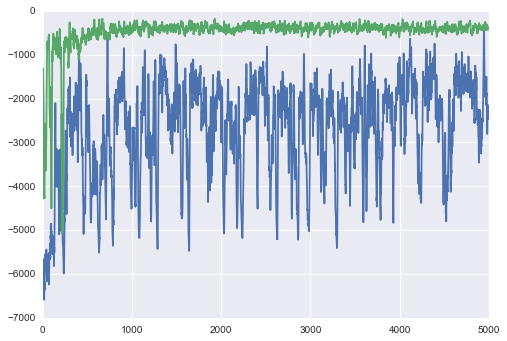

In [57]:
def smooth_graph(yvalues):
    smooth_values = []
    for i in range(len(yvalues) - 10):
        l = yvalues[i:i+10]
        smooth_values.append(sum(l) / 10)
    return smooth_values

plt.plot(smooth_graph(episode_rewards))
plt.plot(smooth_graph(reward_eval))

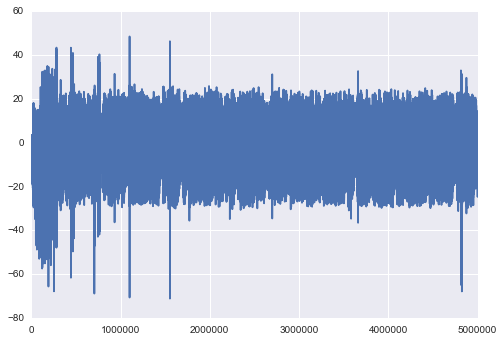

In [44]:
#plot_episode_rewards(episode_rewards)
plt.plot(td_error_all)
pickle.dump(Q, open("Q.p", "wb"))
pickle.dump(Observed_Counts, open("ObservedCounts.p", "wb"))

In [47]:
reward_eval, td_error_eval = qlearning(True, 0)

Episode 0
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900
Episode 1000
Episode 1100
Episode 1200
Episode 1300
Episode 1400
Episode 1500
Episode 1600
Episode 1700
Episode 1800
Episode 1900
Episode 2000
Episode 2100
Episode 2200
Episode 2300
Episode 2400
Episode 2500
Episode 2600
Episode 2700
Episode 2800
Episode 2900
Episode 3000
Episode 3100
Episode 3200
Episode 3300
Episode 3400
Episode 3500
Episode 3600
Episode 3700
Episode 3800
Episode 3900
Episode 4000
Episode 4100
Episode 4200
Episode 4300
Episode 4400
Episode 4500
Episode 4600
Episode 4700
Episode 4800
Episode 4900


In [31]:
plot_episode_rewards(episode_rewards)
import pickle
pickle.dump(Q, open( "q_debug.p", "wb" ) )
pickle.dump(Observed_Counts, open( "Observed_Counts_debug.p", "wb" ) )


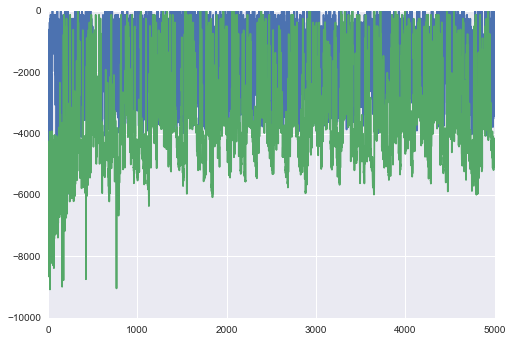

In [51]:
#plot_episode_rewards(episode_rewards)
plt.plot(reward_eval)
plt.plot(episode_rewards)
# pickle.dump(Q, open("Q.p", "wb"))
# pickle.dump(Observed_Counts, open("ObservedCounts.p", "wb"))

In [ ]:
if DEBUG:
    # for key in Observed_Counts:
    #     print key
    #     print Observed_Counts[key]
    #     print '***********************************************'
    # print '############################################'
    # for key in 
    # plt.hist(observed_thetadot, bins=range(-8, 9))
    # plt.show()
    # plt.hist(observed_theta, bins=360)
    # plt.show()
    for key in Q:
        if (key[0] >= 0 and key[0] <=10) or (key[0] >=350):
            print key
            print Q[key]
    print "********************************************************************************************************************************************"
    for key in Observed_Counts:
        if (key[0] >= 0 and key[0] <=10) or (key[0] >=350):
            print "Key: %s, Value:%s" % (key, Observed_Counts[key])
    # fn = "all"
#     plot_hist(all_observed_thetadot, range(-8, 9), fn+"thetadot")
#     plot_hist(all_observed_theta, 360, fn+"theta")
    # pass

In [52]:
import pickle
observed_counts = pickle.load( open( "Observed_Counts_debug.p", "rb" ) )
Q = pickle.load( open( "q_debug.p", "rb" ) )
def render():
    env = gym.make('Pendulum-v0')
    S = env.reset()
    print S
    for t in range(1000):
        dis_S = get_discrete_state(S)
        max_action = max(Q[dis_S], key=Q[dis_S].get)
        S, reward, _, _ = env.step([max_action])
        env.render()
render()

[2016-11-22 21:14:05,309] Making new env: Pendulum-v0


Action Space
Box(1,)
Observation Space
Box(3,)
[ 2.6026026   0.63382441]
